# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Statistical Parametric Mapping

## Todos
- Region of interest in spm
- Do all permutations (`iterations=-1, force_iterations=True`)

## Data description
- 3 files for each position:
    1. `participant_position_CVP`: `Couple_ext`, `Couple_flex`, `Position`, `Vitese` (441, 1 each)
    2. `participant_position_Flex_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21)
    3. `participant_position_Ext_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh` (21, 21)
- We will use `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21) to generate mesh and do the stats

In [1]:
import envergo
import os
import scipy.io as sio
import numpy as np; np.random.seed(0)
import spm1d
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '/home/romain/Desktop/envergo/meshdata/'
files = os.listdir(data_path)

torque = {}

for ifile in files:
    if ifile.endswith('meshdata.mat'):
        participant, position, contraction, ext = ifile.split('_')

        mat = sio.loadmat(os.path.join(data_path, ifile))['Torque4mesh']
        if not position in torque:
            torque[position] = {}
        if contraction in torque[position]:
            torque[position][contraction] = np.dstack((torque[position][contraction], mat))
        else:
            torque[position][contraction] = mat

In [3]:
# create spm matrix (flatten 2D matrix to 1D vector)
contraction = 'Ext'
angle, velocity, participant = torque['Abd90ER']['Ext'].shape
position = len(torque.keys())

participants, positions, y = ([] for i in range(3))

for iparticipant in range(participant):
    for iposition, position_name in enumerate(torque.keys()):
        participants.append(iparticipant)
        positions.append(iposition)
        if iparticipant >= torque[position_name][contraction].shape[2]:
            print('position {} participant {} is nan'.format(position_name, iparticipant))
            # replace missing trial by nan
            y.append(np.full(y[-1].shape[0], np.nan))
        else:
            y.append(torque[position_name][contraction][:, :, iparticipant - 1].flatten())

participants, positions, y = [np.array(i) for i in [participants, positions, y]]
print('----dimension----'.upper())
print('participant: {}'.format(participants.shape))
print('position: {}'.format(positions.shape))
print('y.shape: {}'.format(y.shape))

position Flex180ER participant 29 is nan
position Flex90IR participant 30 is nan
position Flex90ER participant 30 is nan
position Flex180ER participant 30 is nan
position Abd90IR participant 31 is nan
position Flex90IR participant 31 is nan
position Flex90ER participant 31 is nan
position Flex180ER participant 31 is nan
position Abd90IR participant 32 is nan
position Flex90IR participant 32 is nan
position Flex90ER participant 32 is nan
position Flex180ER participant 32 is nan
----DIMENSION----
participant: (198,)
position: (198,)
y.shape: (198, 441)


In [4]:
# replace missing trial by mean of the position
for iposition in np.unique(positions):
    idx = positions == iposition
    mean_vector = np.nanmean(y[idx, :], axis=0)
    y[idx, :] = np.where(np.isnan(y[idx, :]), mean_vector, y[idx, :])

In [5]:
def display_results(spm, drop_non_significative=False, title=None):
    print(spm)
    print(spm.clusters)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    # 1D representation
    spm.plot(ax=axs[0])
    spm.plot_p_values(ax=axs[0])
    spm.plot_threshold_label(ax=axs[0])
    axs[0].set_title('1D representation')
    
    # 2D representation
    z = spm.z.reshape([21, 21])
    zstar = spm.zstar
    if drop_non_significative:
        z[z < zstar] = np.nan
    
    plt.pcolor(z, cmap='viridis')

    # float to int
    envergo.util.axis2int()
    # add color bar
    plt.colorbar(pad=.08)
    
    plt.xlabel('Velocity')
    plt.ylabel('Angle')
    
    axs[1].set_title('2D representation')
    
    # aes
    fig.tight_layout()
    fig.suptitle(title, y=1.05, fontsize=15)
    plt.show()

## One-way repeated-measures ANOVA (non-parametric)

In [ ]:
alpha = 0.05
a_spm = spm1d.stats.nonparam.anova1rm(y, positions, participants)
a_spmi = a_spm.inference(alpha, iterations=1000)

title = 'One-way repeated-measures ANOVA'
display_results(a_spmi, drop_non_significative=True, title=title)

## Post hoc analysis (paired t-test)

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  2.147e+09 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  2.68633
   SPM.h0reject       :  True
   SPM.p              :  (0.011, 0.012, 0.016, 0.017, 0.022)

[Cluster (NonParam)
   threshold       :  2.686
   centroid        :  (9.467, 3.055)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (0.000, 19.426)
   extent          :  19.426
   metric          :  ClusterIntegral
   metric_value    :  7.33418
   nPermUnique     :  2.147e+09 unique permutations possible
   nPermActual     :  1000 actual permutations
   P               :  0.01100

, Cluster (NonParam)
   threshold       :  2.686
   centroid        :  (28.156, 2.917)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (20.035, 36.092)
   extent          :  16.057
   metric          :  ClusterIntegral
   metric_value    :  4.15490
   nPer

/home/romain/miniconda3/envs/envergo/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


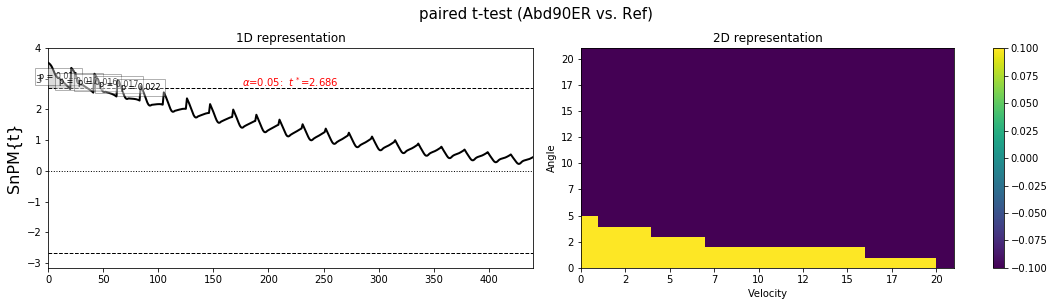

In [10]:
n_positions = len(set(positions))
name_positions = list(torque.keys())
combinations = itertools.combinations(range(1, n_positions+1), 2)


for A, B in combinations:
    yA = y[positions == A]
    yB = y[positions == B]

    alpha = 0.05
    t_spm = spm1d.stats.nonparam.ttest_paired(yA, yB)
    t_spmi = t_spm.inference(alpha, two_tailed=True, iterations=1000)
    
    title = 'paired t-test ({} vs. {})'.format(name_positions[A-1], name_positions[B-1])
    display_results(t_spmi, drop_non_significative=True, title=title)